# Recommendation Systems | Project | Product Recommendations on an e - com website

### Problem Statement: Build your own recommendation system for products on an e-commerce website like Amazon.com.

### Dataset - Amazon Reviews data (http://jmcauley.ucsd.edu/data/amazon/) 

### About Dataset Columns:
First three columns are userId, productId, and ratings and the fourth column is timestamp. You can discard the timestamp column as in this case you may not need to use it.
The repository has several datasets. For this case study, please use the Electronics dataset.
    1. The host page has several pointers to scripts and other examples that can help with parsing the datasets.
    2. The data set consists of:
          i. 7,824,482 Ratings (1-5) for Electronics products.
          ii. Other metadata about products. Please see the description of the fields available on the web page cited above.

## Import all Necessary Modules

In [1]:
# Import Basic Libraries
import numpy as np
import pandas as pd
import os

# Import Datavisualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Set Theme for Data Visualization
%matplotlib inline
sns.set_style('whitegrid')

# Mitigating Warnings
import warnings
warnings.filterwarnings('ignore')

# Import Libraries for Train-Test split, Scaling & Label encoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Import Libraries for developing a recommendation engine
import time
from surprise import Reader, Dataset, SVD, evaluate, accuracy
from surprise.model_selection import GridSearchCV
from surprise.model_selection import KFold
import Recommenders as Recommenders
import Evaluation as Evaluation

## #1. Read and explore the dataset

In [2]:
# 1.1 Read dataset
col_names = ['user_id','product_id','rating','time']
ratingdf = pd.read_csv('ratings_Electronics.csv',names =col_names)
print("Total Number of Rows:",ratingdf.shape[0],"\n")
print("Total Number of Columns:",ratingdf.shape[1],"\n")
ratingdf.head()

Total Number of Rows: 7824482 

Total Number of Columns: 4 



,user_id,product_id,rating,time
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


Insight: We've a dataset with 7824482 rows having details with user_ID, product_ID and there ratings with time stamp. For the given task creating a recommendation system using popularity and collaborative methods we don't need timestamps hence, we can drop it (this will reduce the working file size)

In [3]:
# 1.2 Dropping "time" column
ratingdf.drop("time", axis = 1, inplace = True)

## Data Pre Processing

In [4]:
# DP1 Cleaning any leading/trailing whitespace in the column header
ratingdf.columns = [x.strip() for x in ratingdf.columns]
ratingdf.columns

Index(['user_id', 'product_id', 'rating'], dtype='object')

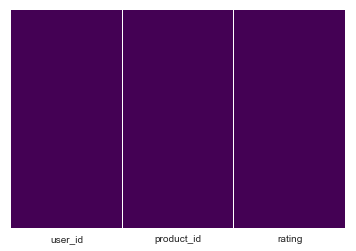

In [5]:
# DP2 Missing Value Treatment

# DP2.1 Identification of missing values through data vicualization
sns.heatmap(ratingdf.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [6]:
# DP2.2 Identification of columns containing missing values (if any)
print("Column Names: \n",pd.DataFrame(ratingdf.isna().any()))

Column Names: 
                 0
user_id     False
product_id  False
rating      False


Dataset is free from missing values

## Exploratory Data Analysis

In [7]:
# 1.3 Count Number of Unique Users and Products in Dataset
users = ratingdf['user_id'].unique()
products = ratingdf['product_id'].unique()
print("Number of Unique Users:", len(users))
print("Number of Unique Products:", len(products))

Number of Unique Users: 4201696
Number of Unique Products: 476002


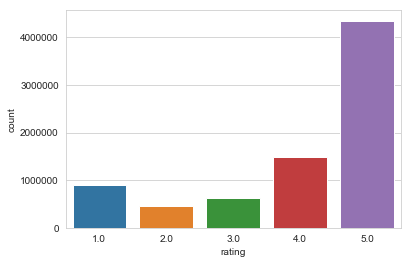

In [8]:
# 1.4 Plotting count of Rating
sns.countplot(data = ratingdf , x = ratingdf['rating'])
plt.show()
#It can be seen that higher ratings are more common amongst users and rating 5 has been rated highest number of times

## #2. Take subset of dataset to make it less sparse/more dense. 

Taking subset of dataset by keeping the users only who has given K (say 30 or 40, depending on developer to choose) or more number of ratings

In [9]:
# Counting the repeate users
counts = ratingdf['user_id'].value_counts()
counts.head()

A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
Name: user_id, dtype: int64

In [10]:
# Creating a subset of given dataset where repeate user >= K (say 30 or 40 depending on developer to choose) i.e. one given user has given atleast 30 ratings
# ratingwf -> rating wokingfile with subset data

k = 30

ratingwf = ratingdf[ratingdf['user_id'].isin(counts[counts >= k].index)]
print("Shape of rating working file (subset data):",ratingwf.shape)
ratio = ratingwf.shape[0]/ratingdf.shape[0]
print("Reduction %age in subset data compared to original dataset:",round((1 - ratio),2))
ratingwf.head()

Shape of rating working file (subset data): (262917, 3)
Reduction %age in subset data compared to original dataset: 0.97


,user_id,product_id,rating
94,A3BY5KCNQZXV5U,0594451647,5.0
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
200,A3BMUBUC1N77U8,0972683275,4.0


## #3. Split the data randomly into train and test dataset

Splitting into 70:30 ratio

In [12]:
# Dividing the dataset into train and test sets
train_data, test_data = train_test_split(ratingwf, test_size = 0.30, random_state=100)
# random state is setting up a seed value

# Shape of training and test feature set
print("Shape of train data:\t",train_data.shape)
print("Shape of test data:\t",test_data.shape)

Shape of train data:	 (184041, 3)
Shape of test data:	 (78876, 3)


## #4. Build Popularity Recommender model

In [13]:
# 4.1 Count Number of Unique Users and Products in Subset Dataset
users = ratingwf['user_id'].unique()
products = ratingwf['product_id'].unique()
print("Number of Unique Users:", len(users))
print("Number of Unique Products:", len(products))

Number of Unique Users: 5276
Number of Unique Products: 81228


In [14]:
# 4.2 Showing the most popular products in the subset dataset (on the basis of counts)
product_grouped = ratingwf.groupby(['product_id']).agg({'rating': 'count'}).reset_index()
grouped_sum = product_grouped['rating'].sum()
product_grouped['percentage']  = product_grouped['rating'].div(grouped_sum)*100
popularity = product_grouped.sort_values(['rating', 'product_id'], ascending = [0,1])
popularity.head(10)

,product_id,rating,percentage
63360,B007WTAJTO,459,0.174580
39692,B003ES5ZUU,399,0.151759
64784,B0088CJT4U,352,0.133883
35933,B002WE6D44,269,0.102314
17278,B000N99BBC,266,0.101173
35711,B002V88HFE,266,0.101173
76186,B00DR0PDNE,261,0.099271
69562,B009SYZ8OC,246,0.093566
24363,B0019EHU8G,242,0.092044
64058,B00829TIEK,238,0.090523


Since in the dataset product name is not given hence, we'll not be able to identify specific product. But, we can identify it through basefiles available in the given link.

In [15]:
# 4.3 Create an instance of popularity based recommender class

pm = Recommenders.popularity_recommender_py() # Note: pm = popularity model
pm.create(train_data, 'user_id', 'product_id')

In [16]:
# Use the popularity based model to make predictions for the user id = 0
user_id = users[0]
pm.recommend(user_id)

,user_id,product_id,score,Rank
51097,A3BY5KCNQZXV5U,B007WTAJTO,307,1.0
31956,A3BY5KCNQZXV5U,B003ES5ZUU,286,2.0
52201,A3BY5KCNQZXV5U,B0088CJT4U,247,3.0
61355,A3BY5KCNQZXV5U,B00DR0PDNE,196,4.0
28893,A3BY5KCNQZXV5U,B002WE6D44,191,5.0
13822,A3BY5KCNQZXV5U,B000N99BBC,182,6.0
28708,A3BY5KCNQZXV5U,B002V88HFE,180,7.0
56061,A3BY5KCNQZXV5U,B009SYZ8OC,180,8.0
19593,A3BY5KCNQZXV5U,B0019EHU8G,170,9.0
51640,A3BY5KCNQZXV5U,B00829TIEK,158,10.0


In [17]:
# Use the popularity based model to make predictions for the user id = 1
user_id = users[1]
pm.recommend(user_id)

,user_id,product_id,score,Rank
51097,AT09WGFUM934H,B007WTAJTO,307,1.0
31956,AT09WGFUM934H,B003ES5ZUU,286,2.0
52201,AT09WGFUM934H,B0088CJT4U,247,3.0
61355,AT09WGFUM934H,B00DR0PDNE,196,4.0
28893,AT09WGFUM934H,B002WE6D44,191,5.0
13822,AT09WGFUM934H,B000N99BBC,182,6.0
28708,AT09WGFUM934H,B002V88HFE,180,7.0
56061,AT09WGFUM934H,B009SYZ8OC,180,8.0
19593,AT09WGFUM934H,B0019EHU8G,170,9.0
51640,AT09WGFUM934H,B00829TIEK,158,10.0


### Note the challenge with popularity based recommendation system is that majority of users gets same recommendation of popular products only. 

## 5. Build Collaborative Filtering model

In [18]:
# 5.1 Pivot Table

# We want the format of ratings matrix to be one row per user and one column per product. 
# We can pivot ratings_df to get that and call the new variable R_df.

R_df = ratingwf.pivot(index = 'user_id', columns ='product_id', values = 'rating').fillna(0)
R_df.tail()

product_id,0594451647,0594481813,0970407998,0972683275,0979526191,1400501466,1400501520,1400501776,1400532620,1400532655,...,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8,B00LMCPYPG,B00LPQRT34
user_id,,,,,,,,,,,,,,,,,,,,,
AZV2U6GU5QA6C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZWQEM8GKXQ5Y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZYJE40XW6MFG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZZ2DEE2NTIM7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZZYW4YOE1B6E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# 5.2  Singular Value Decomposition
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(R_df, k = 50)

# 5.3 Convert sigma values in diag
sigma = np.diag(sigma)

sigma

array([[ 71.55908821,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,  71.71417583,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,  71.90499603, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ..., 123.40076105,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
        139.67074105,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        , 203.17920477]])

In [20]:
# 5.3 Creating all user predicted rating to be used in our recommendation engine

# We also need to add the user means back to get the predicted 5-star ratings
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = R_df.columns)
preds_df.head()

product_id,0594451647,0594481813,0970407998,0972683275,0979526191,1400501466,1400501520,1400501776,1400532620,1400532655,...,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8,B00LMCPYPG,B00LPQRT34
0,0.005291,0.004401,0.020462,-0.004826,0.000767,0.000623,-0.001725,0.016936,0.012985,0.056992,...,0.002359,-0.036514,-0.001082,0.011032,-0.001304,-0.078278,-0.017799,-0.005671,-0.000516,-0.002376
1,0.006099,-0.011533,0.002339,0.129005,0.004113,0.005153,-0.011019,0.036775,0.007163,0.027581,...,0.004096,0.010362,-0.026117,0.002568,-0.004901,-0.091672,-0.052871,0.024825,-0.000138,-0.000452
2,-0.000134,-0.000418,0.000704,0.000386,0.000039,0.001269,0.000008,-0.001233,0.000262,-0.000971,...,0.000208,0.005923,-0.002330,-0.000799,0.001147,-0.008742,0.001373,0.002270,0.000154,0.000182
3,-0.003515,0.002561,0.001634,-0.015465,0.001470,0.010734,0.002953,-0.005500,0.004774,-0.001132,...,-0.000091,-0.038662,0.026011,-0.005602,-0.009600,0.089501,-0.044347,-0.000060,-0.000089,0.004680
4,0.000419,0.002996,-0.000766,0.009508,0.000739,-0.001893,-0.002863,-0.005144,0.000304,-0.002218,...,-0.005009,-0.012493,0.012528,0.017336,0.000351,0.011614,0.015682,-0.007812,-0.000149,-0.000401


In [21]:
# 5.4 Creation of Collaborative Recommendation Engine

# return the product with the highest predicted rating that the specified user hasn’t already rated
#Take specific user row from matrix from predictions

def recommend_product(predictions_df, userID, original_ratings_df, num_recommendations):
    
    # Get and sort the user's predictions
    user_row_number = userID - 1 # UserID starts at 1, not 0
    sorted_user_predictions = predictions_df.iloc[user_row_number].sort_values(ascending=False)
    
    # Get the user's data
    user_data = original_ratings_df[original_ratings_df.user_id == users[userID]]
    user_full = user_data
    
    # Print Specific Message
    print ('User {0} has already rated {1} products.'.format(userID, user_full.shape[0]))
    print ('Recommending the highest {0} predicted ratings products not already rated.'.format(num_recommendations))
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (original_ratings_df[~original_ratings_df['product_id'].isin(user_data['product_id'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'product_id',
               right_on = 'product_id').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations, sorted_user_predictions, user_data, user_full

# Recommendation for First user
already_rated, Predictions, sorted_user_predictions, user_data, user_full = recommend_product(preds_df, 1, ratingwf, 10)

User 1 has already rated 110 products.
Recommending the highest 10 predicted ratings products not already rated.


In [22]:
# 5.4.1 Output 1 - Already Rated 
already_rated

,user_id,product_id,rating
118,AT09WGFUM934H,0594481813,3.0
77282,AT09WGFUM934H,B00005105L,5.0
160734,AT09WGFUM934H,B000068O1M,5.0
160973,AT09WGFUM934H,B000068O34,5.0
162248,AT09WGFUM934H,B000068O4J,5.0
162283,AT09WGFUM934H,B000068O4N,5.0
169871,AT09WGFUM934H,B00006B7DA,4.0
366106,AT09WGFUM934H,B00015Y0FK,5.0
412572,AT09WGFUM934H,B0001Y7UAI,1.0
639325,AT09WGFUM934H,B00080G0BK,4.0


In [23]:
# 5.4.2 Output 2 - Top 10 Recommendations
Predictions

,user_id,product_id,rating
43476,AYZWH0EYHFTPG,B000LRMS66,5.0
43517,A1ODOGXEYECQQ8,B000LRMS66,5.0
43510,A2S26YGSVXBCFL,B000LRMS66,5.0
43511,A1ZM846Y7AUYD,B000LRMS66,5.0
43512,A3A57GX8FJ4QNQ,B000LRMS66,3.0
43513,A1C05TSWTI3VZ5,B000LRMS66,5.0
43514,A3FO94MKFID2DK,B000LRMS66,5.0
43515,A33XMCG1UFDSY2,B000LRMS66,4.0
43516,A6ZPLVAUQ6695,B000LRMS66,5.0
43518,A341HCMGNZCBIT,B000LRMS66,5.0


## #6. Evaluate both the models. (Once the model is trained on the training data, it can be used to compute the error (RMSE) on predictions made on the test data.)

Evaluation of models through RMSE wasn't covered in Residency 5. I tried working out this with the help of Scikit-Surprise packages but due to computational issues unable to perform the task.

## #7. Get top - K (K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits,we will recommend 5 new products.

In [25]:
# 7.1 User to provide value for Numer of recommendations (K)

k = 5

# taking k = 5 in this case

def recommend_product(predictions_df, userID, original_ratings_df, num_recommendations):
    
    # Get and sort the user's predictions
    user_row_number = userID - 1 # UserID starts at 1, not 0
    sorted_user_predictions = predictions_df.iloc[user_row_number].sort_values(ascending=False)
    
    # Get the user's data
    user_data = original_ratings_df[original_ratings_df.user_id == users[userID]]
    user_full = user_data
    
    # Print Specific Message
    print ('User {0} has already rated {1} products.'.format(userID, user_full.shape[0]))
    print ('Recommending the highest {0} predicted ratings products not already rated.'.format(num_recommendations))
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (original_ratings_df[~original_ratings_df['product_id'].isin(user_data['product_id'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'product_id',
               right_on = 'product_id').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations, sorted_user_predictions, user_data, user_full

# Recommendation for First user
already_rated, Predictions, sorted_user_predictions, user_data, user_full = recommend_product(preds_df, 1, ratingwf, k)
Predictions

User 1 has already rated 110 products.
Recommending the highest 5 predicted ratings products not already rated.


,user_id,product_id,rating
43476,AYZWH0EYHFTPG,B000LRMS66,5.0
43517,A1ODOGXEYECQQ8,B000LRMS66,5.0
43510,A2S26YGSVXBCFL,B000LRMS66,5.0
43511,A1ZM846Y7AUYD,B000LRMS66,5.0
43512,A3A57GX8FJ4QNQ,B000LRMS66,3.0


In [26]:
# Recommendation for Second User
already_rated, Predictions, sorted_user_predictions, user_data, user_full = recommend_product(preds_df, 2, ratingwf, k)
Predictions

User 2 has already rated 72 products.
Recommending the highest 5 predicted ratings products not already rated.


,user_id,product_id,rating
118982,AZD8SMNGQI98O,B003ES5ZUU,5.0
119179,A1CMD08Z49PGKQ,B003ES5ZUU,5.0
119189,A2Q204DY2L7YRP,B003ES5ZUU,5.0
119188,A11FX8HL2ANK6T,B003ES5ZUU,5.0
119187,A3V1A3C9DTLPME,B003ES5ZUU,5.0


## #8. Summarise your insights

1. In case of Popularity Based Recommendation System - It's generic in nature and can be used for recommending top popular products to the users. In this case each user will view top popular products on there homepage for recommendation.

2. In case of Collaborative Recommendation System - We can recommend products based on ratings given by the user to different products. This one is more niche in nature where each user will have recommendation based on the products purchased/ ratings given

3. We can use Scikit-Surprise Package or Turicreate Package to develop the recommendation engine but due to huge data these packages will require heavy computational power to perform develop the model